<a href="https://colab.research.google.com/github/Unoaccaso/lab_projects/blob/master/grid_dasmanettare_per_rick_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulazioni numeriche per fenomeni d'interferenza

In [0]:
# ===================================
# Importing useful libraries
# ===================================

# we choose numpy to handle matrices and vectors
import numpy as np 
# library optimized for programs running on a GPU
try:
  import cupy as cp
except ModuleNotFoundError:
  !pip install cupy-cuda101
  import cupy as cp
#import numpy as cp
from time import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

Intervallo delle x:[(array(-0.04), array(0.03999876))]


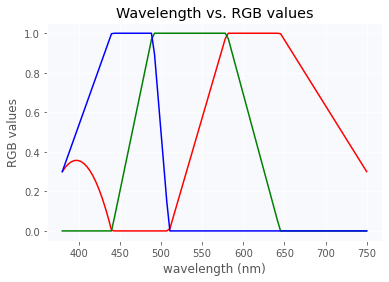

In [25]:
# ==================== 
# Physical Parameters  
# ====================
Ip = 4**2                 # intensity peak              
Ib = 1.0                  # background illumination                       
Lambda = 0.85e-6          # wavelength, [lambda] = m
k0 = 2*np.pi/Lambda       # vacuum wavevector, [k0] = m^(-1)                 
n0 = 1.                   # background index of refraction      
Lz = 0.12                 # computational length of sample, [Lz] = m     
Lx = 80e-3                # computational width of sample, [Lx] = m          

w0 = 0.25e-3              # beam width of gaussian beam parameter

h = 0.67e-3               # slit separation, [h] = m
inputposition=+h/2        # input position 

# =========================
# Computational Parameters 
# =========================
nstepx = 2024*32          # number of transverse grid points
nstepz = 1024             # number of longitudinal propagation steps

deltax = Lx/nstepx        # resolution in the x direction, [deltax] = m
deltaz = Lz/nstepz        # resolution in the z direction, IMPORTANT, [deltaz] = m
deltaf = 1/Lx             # spatial frequency step, [deltaf] = m^(-1)

# ===================
# Meshgrid generation
# ===================
z = cp.arange(0, Lz+deltaz, deltaz)                
x = -Lx/2 + (cp.arange(0, nstepx, 1))*deltax
print(f'Intervallo delle x:[{x.min(), x.max()}]')
# =====================
# Dispersive Step Setup
# =====================
# this is to get rid of fft shifts and the sort

ntx = 0     
kx = cp.zeros(nstepx)                              
for nn in range(nstepx):
    ikx = nn - ntx
    kx[nn]=2*np.pi*deltaf*ikx
    if nn + 1 - nstepx/2 == 0:
      ntx = nstepx
      
# =======================
# Input fields definition  
# =======================
def Gaussian(x, Ip = Ip, w0=w0):
  return cp.sqrt(Ip)*cp.exp(-(x**2)/(w0**2))

# ================
# Propagation loop
# ================
def propagate(Field, k = k0, nstepz=nstepz, deltaz=deltaz, keep_memory=False):
  # Fast fourier transform api
  fft, ifft = cp.fft.fft, cp.fft.ifft # faster with big matrices
  if keep_memory:
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepz+1))
    FieldModuleMemory[:, 0] = cp.abs(Field)
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(kx**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  tstart = time()
  for hh in range(nstepz):
      
      FieldTransform = fft(Field)*Propagator
      Field = ifft(FieldTransform)

      if keep_memory:
        FieldModuleMemory[:, 1+hh] = cp.abs(Field)

  print(f'elapsed time:{time()-tstart}')
  return Field, FieldModuleMemory

# =================
# Plotting function
# =================
def plot(Power, figsize=(15, 15), width=40, unit="mm"):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

# =============================
# To convert wavelength to cmap
#==============================
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning an approximated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength) #must be expressed in nm
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment
#Lambda*1e9 is expressed in nm

# ======================
# To plot final spectrum
# ======================
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/(wavelength) #here k is expressed in 10^9 m^(-1)
  OutputField, FieldModuleMemory = propagate(InputField, k, keep_memory=True)
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9), OutputField, FieldModuleMemory #wavelenght*1e9 is expressed in nm

# ====================
# Show result function
# ====================
def show_results(OutputPower, FieldModuleMemory, Color):
  fig = plt.figure(constrained_layout=True, figsize=(20, 20))
  gs = fig.add_gridspec(3, 3)

  ax1 = fig.add_subplot(gs[0, :2])
  ax1.set_title('Output power spectrum')
  ax1.plot(cp.asnumpy(x), cp.asnumpy(OutputPower))

  ax2 = fig.add_subplot(gs[1, :2])
  ax2.set_title('Diffracted light')
  ax2.imshow(cp.asnumpy(Color), extent=[x.min(), x.max(), 0, 1], aspect='auto')
  ax2.grid(False)

  ax3 = fig.add_subplot(gs[:2, 2])
  ax3.set_title('Diffracted light')
  ax3.imshow(cp.asnumpy(cp.abs(FieldModuleMemory.T)**2), origin='lower', 
             extent=[-0.02, 0.02, z.min(), z.max()], aspect = 'auto', 
             cmap='hot')
  ax3.grid(False)
  plt.show()
  plt.close()

fraunhofer distance: >>0.376


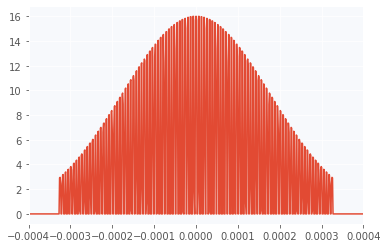

In [26]:
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 0.65e-5               # distance betwen slices, [dist] = m
width = 0.15e-5              # width of slices, [width] = m
N = 50                       # slice number

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=w0)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(cp.asnumpy(x), cp.asnumpy(InputField))
plt.xlim((-N*(dist+width), N*(dist+width)))
print(f'fraunhofer distance: >>{(N*(dist+width)*2)**2/2/Lambda:.3f}')

In [27]:
# =====================
# Red light propagation
# =====================
Red, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, Lambda)
OutputPower = cp.abs(OutputField)**2

elapsed time:0.5068144798278809


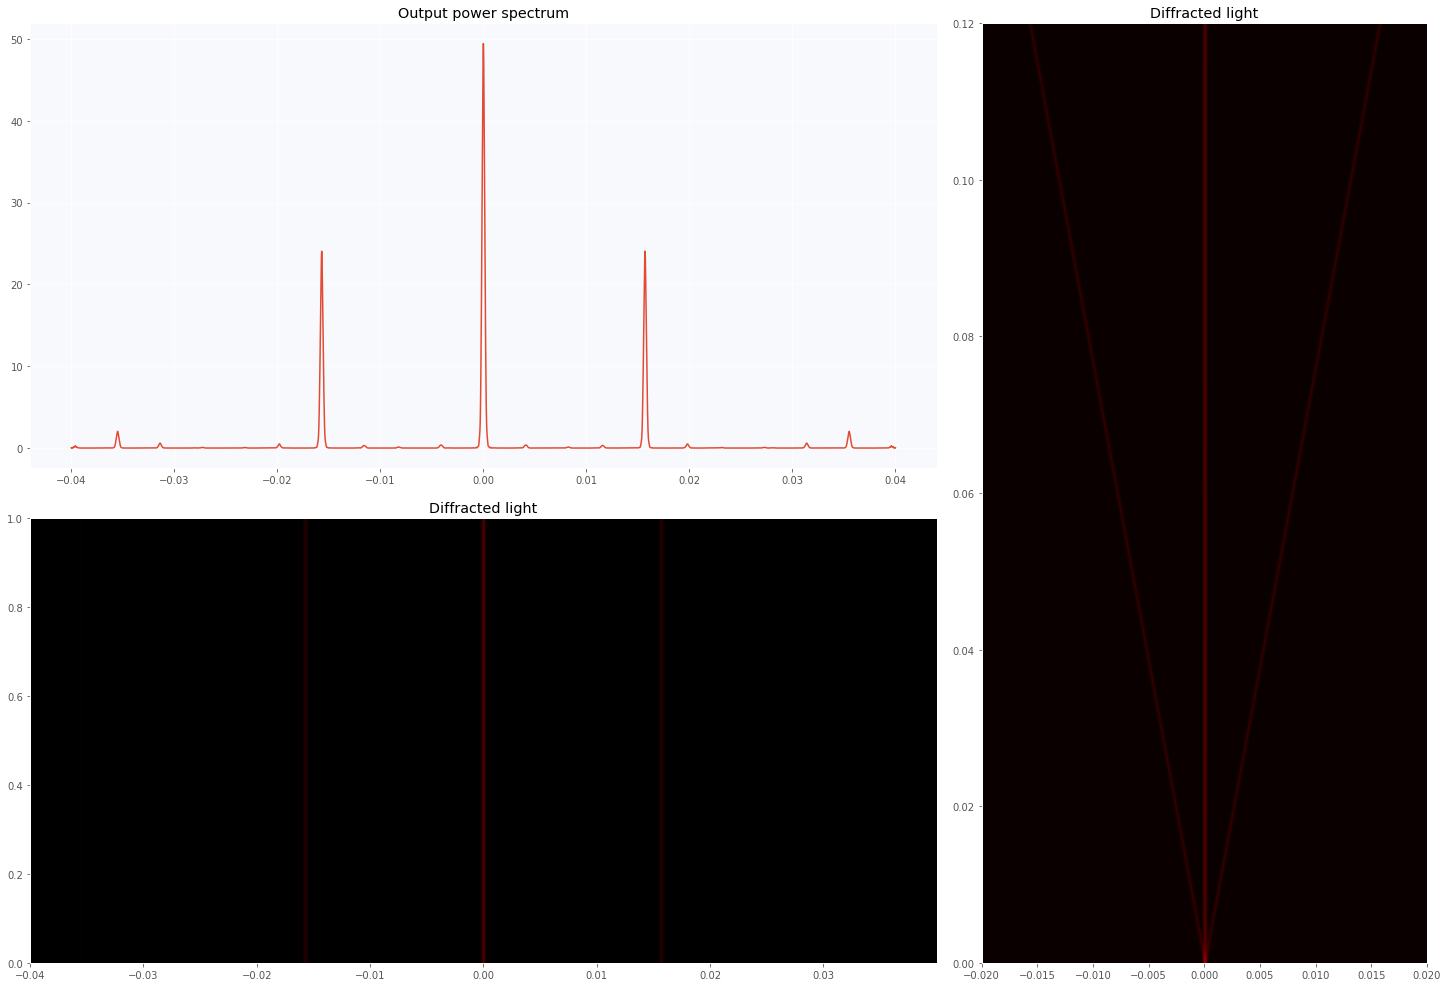

In [28]:
show_results(OutputPower, FieldModuleMemory[cp.abs(x) <= 0.02, :], Red)

In [29]:
# =======================
# White light propagation
# =======================
''' making color array '''
wavelengths = cp.linspace(400, 750, 40)*1e-9 #here the wavelenghts are expressed in m
Color, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, 500*1e-9)
for wavelength in wavelengths:
  Color_t, OutputField_t, FieldModuleMemory_t = propagate_and_get_rgb(InputField, wavelength)
  Color += Color_t
  OutputField += OutputField_t
  FieldModuleMemory += FieldModuleMemory_t

elapsed time:0.5471174716949463
elapsed time:0.5017955303192139
elapsed time:0.4962458610534668
elapsed time:0.5065159797668457
elapsed time:0.499880313873291
elapsed time:0.49567294120788574
elapsed time:0.4953157901763916
elapsed time:0.4957253932952881
elapsed time:0.5038938522338867
elapsed time:0.492969274520874
elapsed time:0.4917750358581543
elapsed time:0.5153794288635254
elapsed time:0.49451494216918945
elapsed time:0.49971795082092285
elapsed time:0.49524450302124023
elapsed time:0.4905879497528076
elapsed time:0.49832606315612793
elapsed time:0.4949629306793213
elapsed time:0.4950435161590576
elapsed time:0.4983820915222168
elapsed time:0.5151534080505371
elapsed time:0.492034912109375
elapsed time:0.4956221580505371
elapsed time:0.5353705883026123
elapsed time:0.5497069358825684
elapsed time:0.5490736961364746
elapsed time:0.5039710998535156
elapsed time:0.5271391868591309
elapsed time:0.4960775375366211
elapsed time:0.48737573623657227
elapsed time:0.49891090393066406
elap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


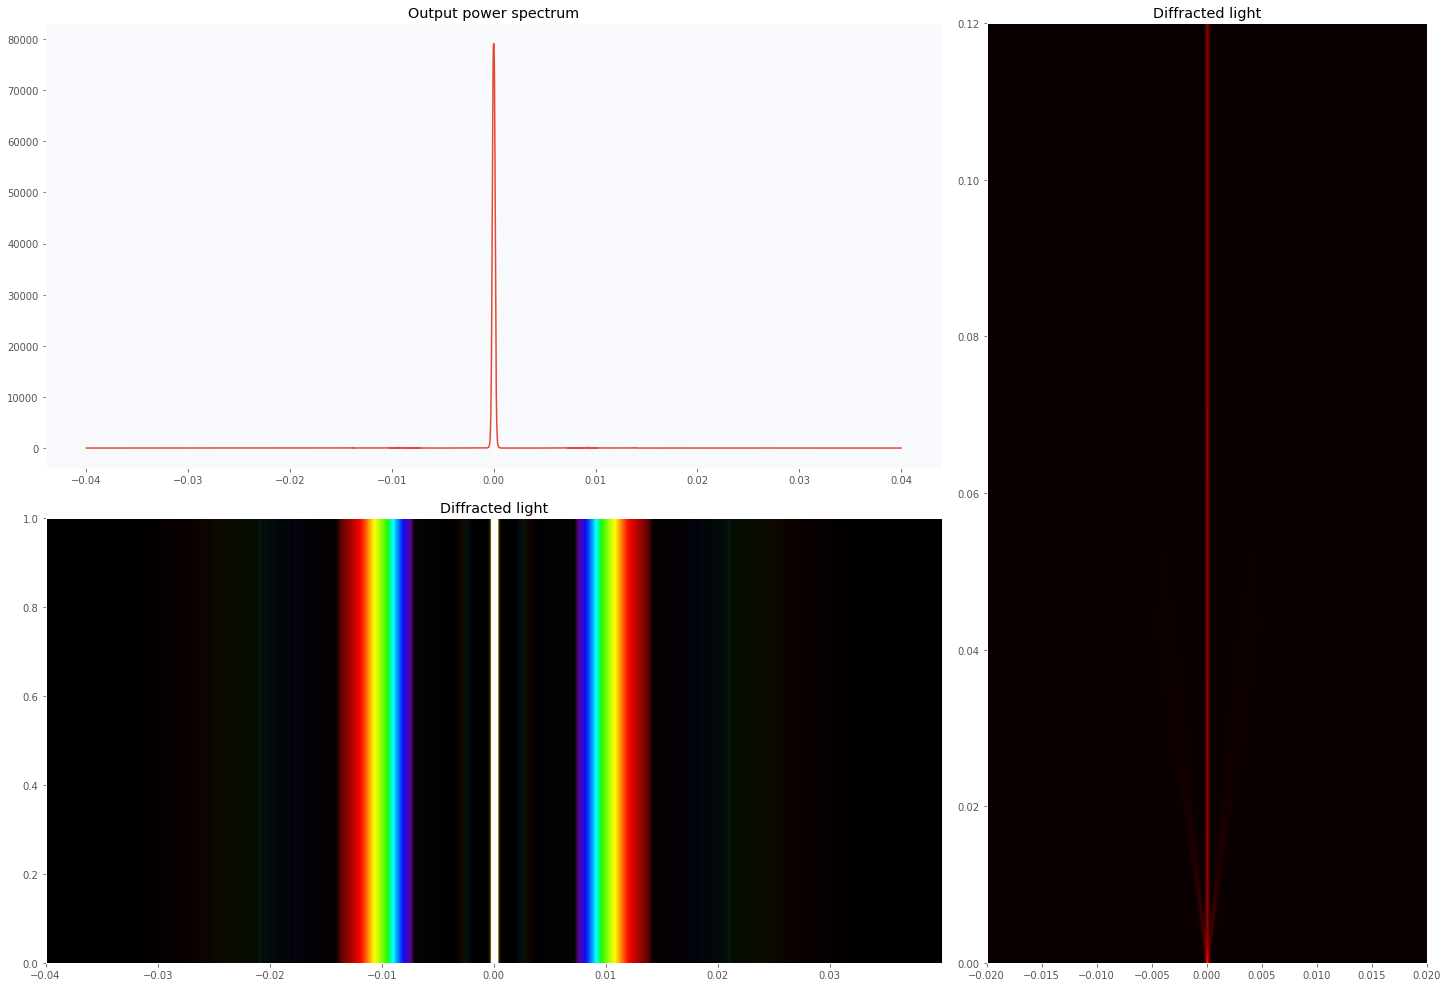

In [30]:
show_results(cp.abs(OutputField)**2, FieldModuleMemory[cp.abs(x) <= 0.02, :], Color)